In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import plotting_utils as pu
import overview_plot_utils as opu
import sa_city_utils as sacu

from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, trend_metric_ids
from utils import city_list

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

## Useful plotting functions

In [6]:
def plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary, limits=None, store=True, legend=0, read_samples=True, title=None):
    # Make axes
    fig, axs = plt.subplots(2, len(metric_ids), height_ratios=[4, 1], figsize=(4*len(metric_ids),11))
    fig.suptitle(f"{pu.city_names[city]} {title}", fontweight='bold', fontsize=14)

    # Loop through examples
    for idx, metric_id in enumerate(metric_ids):
        axs_subset = axs[:,idx]

        pu.plot_city_results(
            city = city,
            metric_id = metric_id,
            plot_col = plot_col,
            hist_slice = hist_slice,
            proj_slice = proj_slice,
            fit_method = fit_method,
            stationary = stationary,
            axs = axs_subset,
            read_samples = read_samples,
            limits = limits[idx] if type(limits) == list else None,
            yticklabels = True if idx == 0 else False,
            legend = True if idx == legend else False,
        )

    plt.tight_layout()
    
    if store:
        plt.savefig(f'../figs/si/{city}_{plot_col}_{fit_method}_{stationary}_{hist_slice}_{proj_slice}.pdf')
    else:
        plt.show()

# Plots

## Figure 1

In [4]:
# Read timeseries
city = "boston"
metric_id = "max_tasmax"
var_id = metric_id.split('_')[1]
unit = '[C]'

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

# Filter unrealistic values
df = df.query('tasmax < 50')

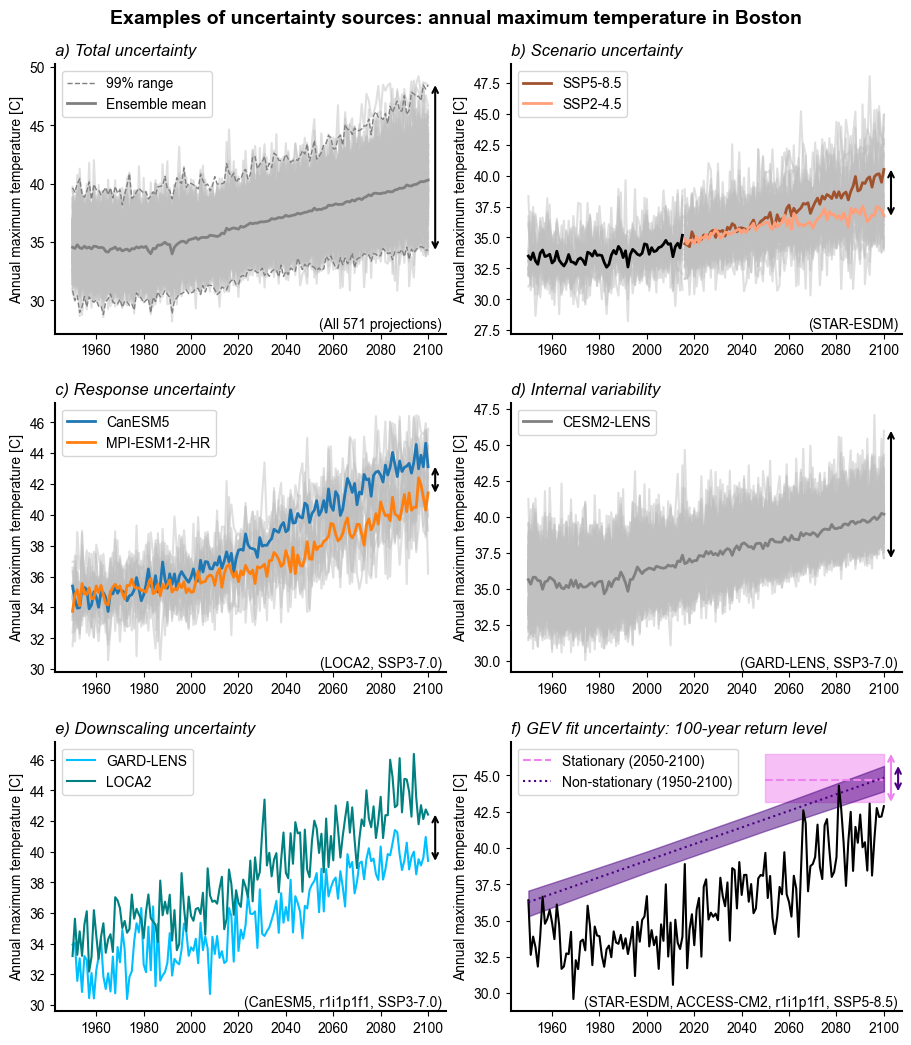

In [5]:
plt.rcParams["font.size"] = 10

# layout = """
# aabb
# ccdd
# .ee.
# """

## Timeseries plots
# fig = plt.figure(figsize=(9,10), layout='constrained')
# axs = fig.subplot_mosaic(
#     layout,
#     gridspec_kw={'hspace':0.075, 'wspace':0.01}
# )
fig, axs = plt.subplots(3, 2, figsize=(9,10), layout='constrained', gridspec_kw={'hspace':0.075, 'wspace':0.01})

opu.plot_total_uncertainty(df, metric_id, unit, axs[0,0])
opu.plot_scenario_uncertainty(df, metric_id, unit, axs[0,1])
opu.plot_response_uncertainty(df, metric_id, unit, axs[1,0])
opu.plot_internal_variability(df, metric_id, unit, axs[1,1])
opu.plot_downscaling_uncertainty(df, metric_id, unit, axs[2,0])
_ = opu.plot_gev_uncertainty(df, metric_id, unit, axs[2,1], city=city)

fig.suptitle('Examples of uncertainty sources: annual maximum temperature in Boston', fontweight='bold', fontsize=14, y=1.03)

plt.savefig('../figs/main/final/figure1.png', dpi=600, bbox_inches='tight')
# plt.show()

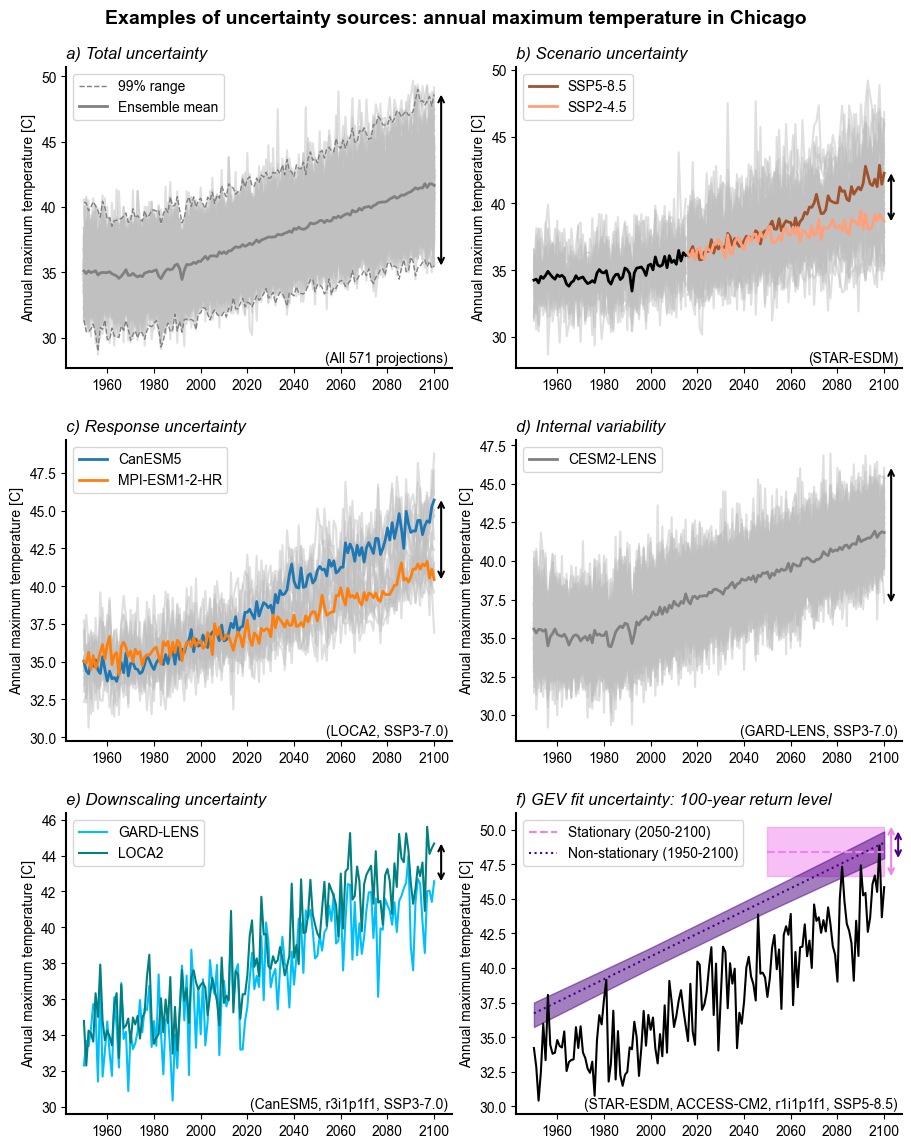

In [7]:
# Read timeseries
city = "chicago"
metric_id = "max_tasmax"
var_id = metric_id.split('_')[1]
unit = '[C]'

# Read raw
df = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

# Drop TaiESM1
df = df[df['gcm'] != 'TaiESM1']

# Filter unrealistic values
df = df.query('tasmax < 50')

## Timeseries plots
fig, axs = plt.subplots(3, 2, figsize=(9,11), layout='constrained', gridspec_kw={'hspace':0.075, 'wspace':0.01})

opu.plot_total_uncertainty(df, metric_id, unit, axs[0,0])
opu.plot_scenario_uncertainty(df, metric_id, unit, axs[0,1])
opu.plot_response_uncertainty(df, metric_id, unit, axs[1,0])
opu.plot_internal_variability(df, metric_id, unit, axs[1,1])
opu.plot_downscaling_uncertainty(df, metric_id, unit, axs[2,0], member = 'r3i1p1f1')
_ = opu.plot_gev_uncertainty(df, metric_id, unit, axs[2,1], city=city)

fig.suptitle('Examples of uncertainty sources: annual maximum temperature in Chicago', fontweight='bold', fontsize=14, y=1.03)

# plt.savefig('../figs/chicago_all.png', dpi=600, bbox_inches='tight')
plt.show()

# Other

### Robustness checks

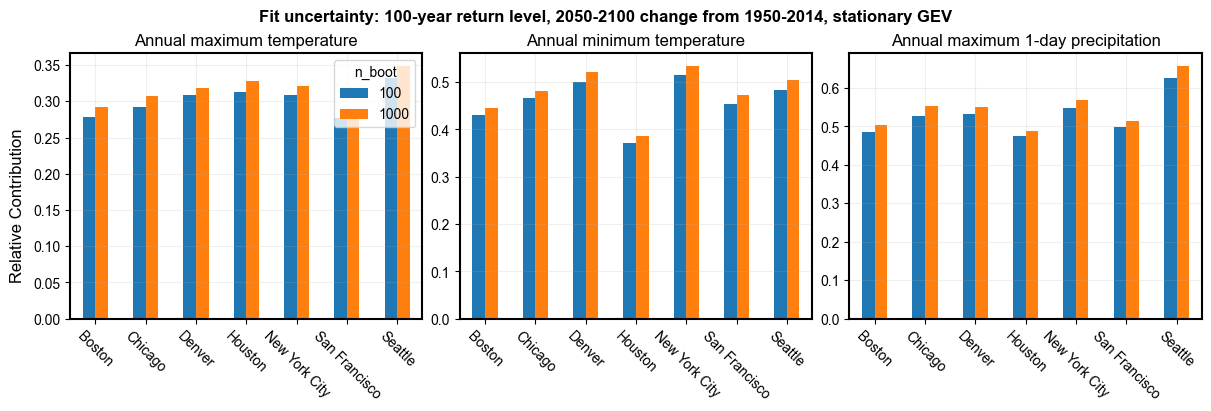

In [54]:
# Stationary check
n_boot_hist = 1
sample_str = "_samples"
stationary = 'stat'
fit_method = 'lmom'
proj_slice = '2050-2100'
hist_slice = '1950-2014'
plot_col = '100yr_return_level_diff'

cities = list(city_list.keys())
cities.remove('nashville')

df_check = pd.DataFrame()

for city in cities:
    for metric_id in gev_metric_ids[:3]:
        # Read all
        df_1000 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nbootproj1000_nboothist{n_boot_hist}{sample_str}.csv")
        uc_1000 = sacu.calculate_df_uc(df_1000, plot_col).set_index('uncertainty_type')
        df_100 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{hist_slice}_{proj_slice}_{fit_method}_{stationary}_nbootproj100_nboothist{n_boot_hist}{sample_str}.csv")
        uc_100 = sacu.calculate_df_uc(df_100, plot_col).set_index('uncertainty_type')

        # Append
        df_tmp = pd.DataFrame(data={'city': [city, city],
                                    'metric_id': [metric_id, metric_id],
                                    'n_boot': [100, 1000],
                                    'fit_uc_mean': [uc_100.loc['fit_uc']['mean']/uc_100.loc['uc_99w_main']['mean'],
                                                    uc_1000.loc['fit_uc']['mean']/uc_1000.loc['uc_99w_main']['mean']],
                                    'fit_uc_std': [uc_100.loc['fit_uc']['std']/uc_100.loc['uc_99w_main']['mean'],
                                                   uc_1000.loc['fit_uc']['std']/uc_1000.loc['uc_99w_main']['mean']]},
                              index=[0,1])
        df_check = pd.concat([df_check, df_tmp], ignore_index=True)

# Plot
fig, axs = plt.subplots(1,3, figsize=(12,4), layout='constrained')

for idx, metric_id in enumerate(gev_metric_ids[:3]):
    ax = axs[idx]
    dfp = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_mean')
    # yerr = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_std')
    dfp.plot(kind='bar', rot=0, capsize=3, ax=ax)
    ax.grid(alpha=0.2)
    ax.set_xticklabels([pu.city_names[city] for city in dfp.index], rotation=-45)
    ax.set_xlabel('')
    ax.set_title(pu.title_labels[metric_id])
    if idx != 0:
        ax.get_legend().remove()

fig.suptitle('Fit uncertainty: 100-year return level, 2050-2100 change from 1950-2014, stationary GEV', fontweight='bold')
fig.supylabel('Relative Contribution')

plt.savefig('../figs/si/city_nboot_check_stat_change.pdf', bbox_inches='tight')

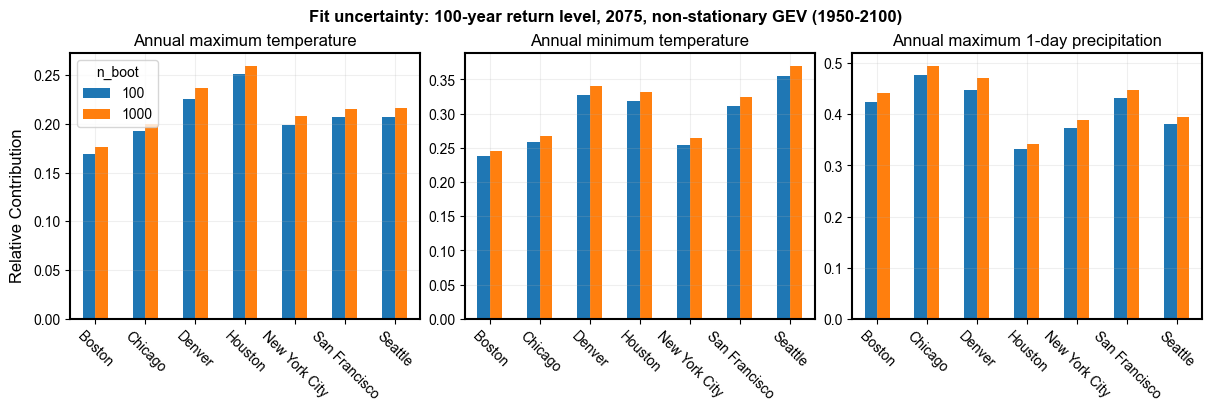

In [55]:
# Non-stationary check
n_boot = 1
sample_str = "_samples"
stationary = 'nonstat'
fit_method = 'mle'
proj_slice = '1950-2100'
plot_col = '100yr_return_level_2075'

df_check = pd.DataFrame()

cities = list(city_list.keys())
cities.remove('nashville')

for city in cities:
    for metric_id in gev_metric_ids[:3]:
        # Read all
        df_1000 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stationary}_nboot1000{sample_str}.csv")
        uc_1000 = sacu.calculate_df_uc(df_1000, plot_col).set_index('uncertainty_type')
        df_100 = pd.read_csv(f"{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_{proj_slice}_{fit_method}_{stationary}_nboot100{sample_str}.csv")
        uc_100 = sacu.calculate_df_uc(df_100, plot_col).set_index('uncertainty_type')

        # Append
        df_tmp = pd.DataFrame(data={'city': [city, city],
                                    'metric_id': [metric_id, metric_id],
                                    'n_boot': [100, 1000],
                                    'fit_uc_mean': [uc_100.loc['fit_uc']['mean']/uc_100.loc['uc_99w_main']['mean'],
                                                    uc_1000.loc['fit_uc']['mean']/uc_1000.loc['uc_99w_main']['mean']],
                                    'fit_uc_std': [uc_100.loc['fit_uc']['std']/uc_100.loc['uc_99w_main']['mean'],
                                                   uc_1000.loc['fit_uc']['std']/uc_1000.loc['uc_99w_main']['mean']]},
                              index=[0,1])
        df_check = pd.concat([df_check, df_tmp], ignore_index=True)

# Plot
fig, axs = plt.subplots(1,3, figsize=(12,4), layout='constrained')

for idx, metric_id in enumerate(gev_metric_ids[:3]):
    ax = axs[idx]
    dfp = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_mean')
    # yerr = df_check[df_check['metric_id'] == metric_id].pivot(index='city', columns='n_boot', values='fit_uc_std')
    dfp.plot(kind='bar', rot=0, capsize=3, ax=ax)
    ax.grid(alpha=0.2)
    ax.set_xticklabels([pu.city_names[city] for city in dfp.index], rotation=-45)
    ax.set_xlabel('')
    ax.set_title(pu.title_labels[metric_id])
    if idx != 0:
        ax.get_legend().remove()

fig.suptitle('Fit uncertainty: 100-year return level, 2075, non-stationary GEV (1950-2100)', fontweight='bold')
fig.supylabel('Relative Contribution')

plt.savefig('../figs/si/city_nboot_check_nonstat_abs.pdf', bbox_inches='tight')

### Cities

In [4]:
import importlib
importlib.reload(pu)

<module 'plotting_utils' from '/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/src/plotting_utils.py'>

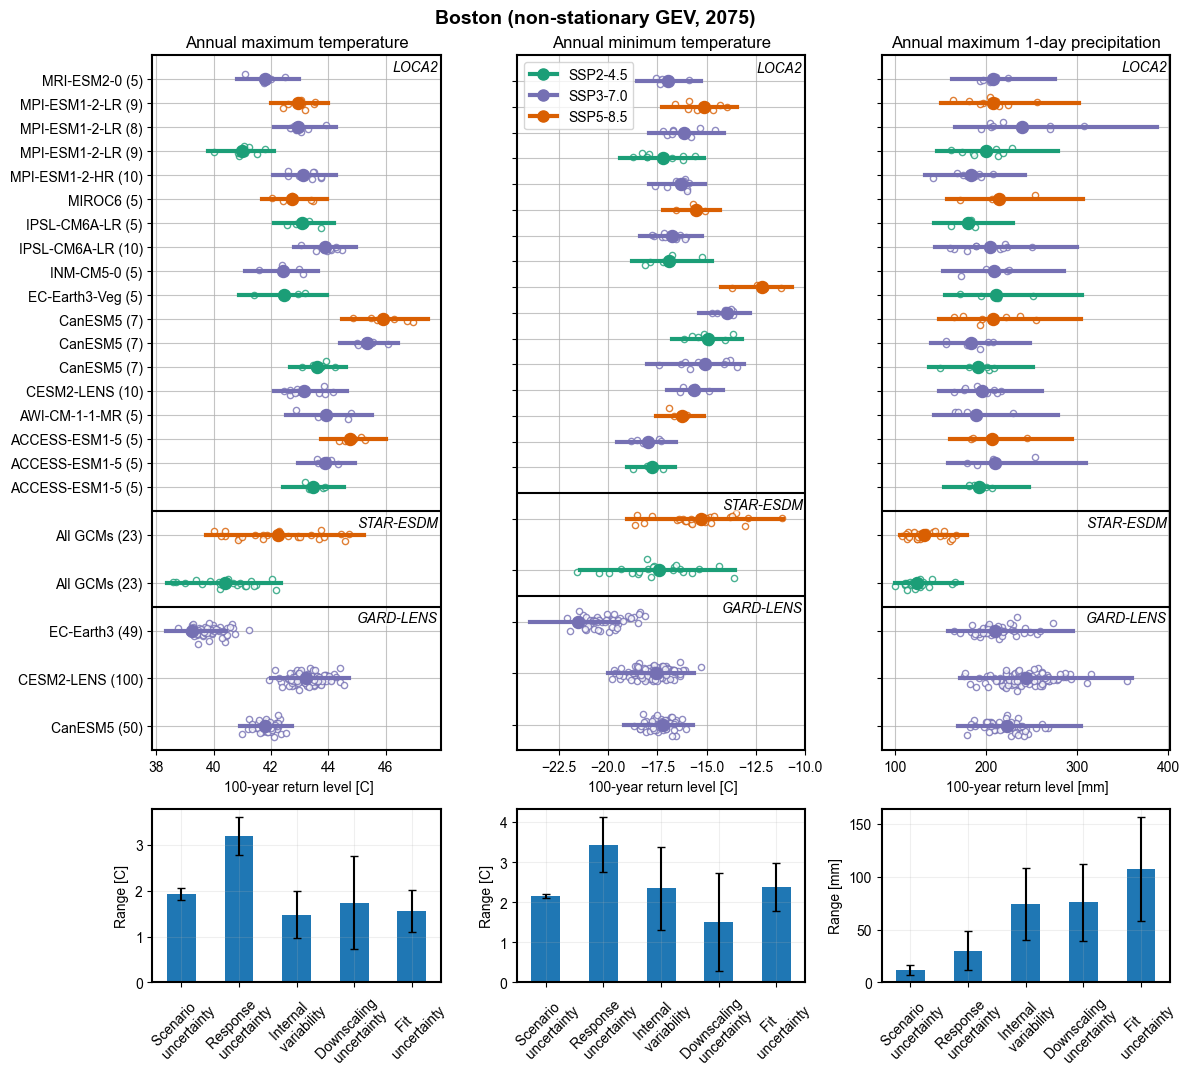

In [8]:
city = 'boston'
plot_col = '100yr_return_level_2075'
hist_slice = None
proj_slice = '1950-2100'
fit_method = 'mle'
stationary = False

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary,
                  title = '(non-stationary GEV, 2075)',
                  legend=1)

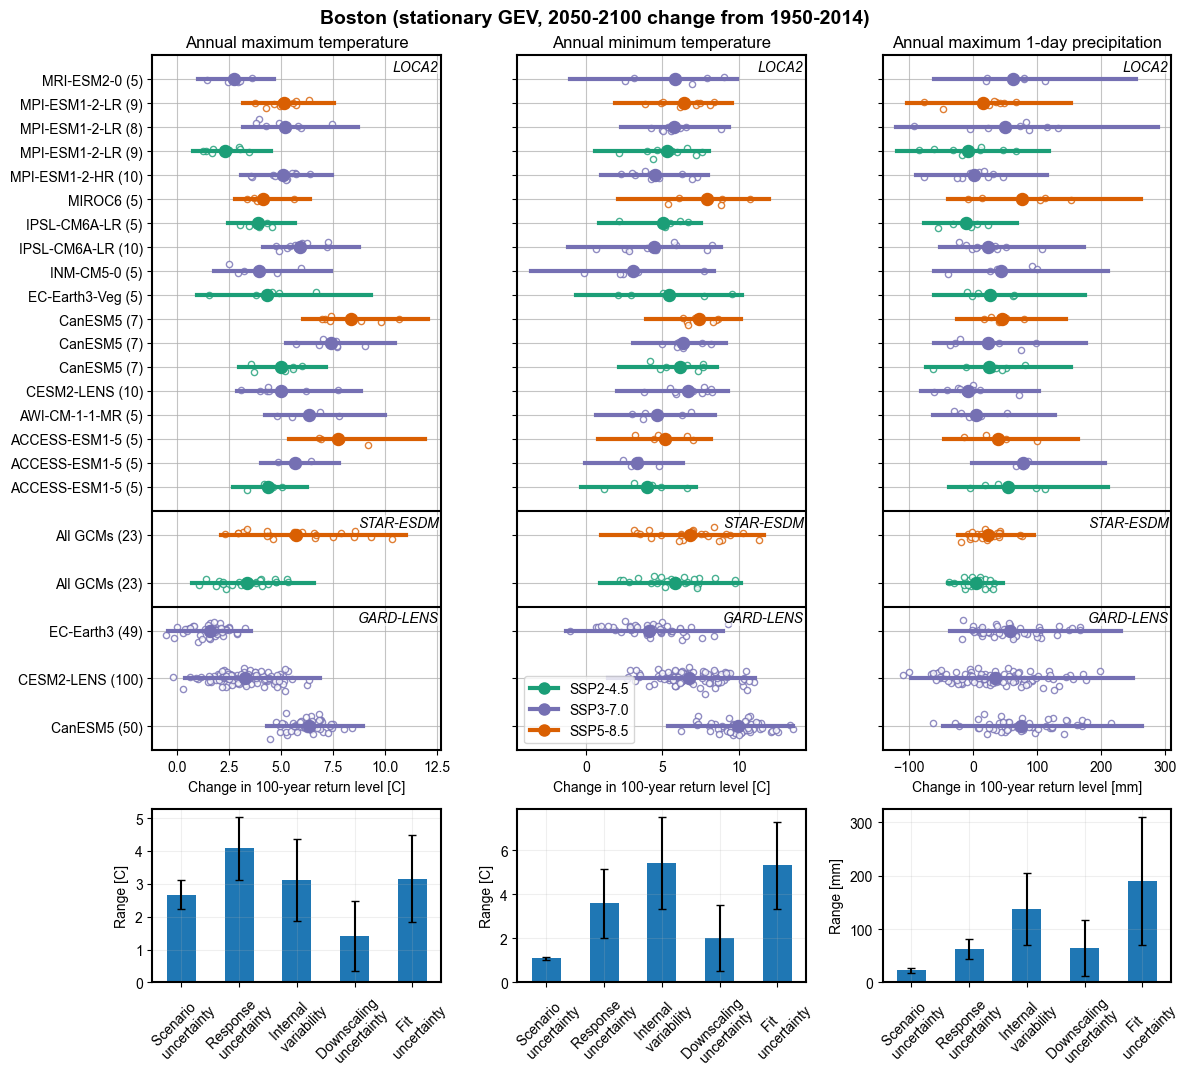

In [9]:
city = 'boston'
plot_col = '100yr_return_level_diff'
hist_slice = '1950-2014'
proj_slice = '2050-2100'
fit_method = 'lmom'
stationary = True

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

plot_city_metrics(city, metric_ids, plot_col, hist_slice, proj_slice, fit_method, stationary,
                  title = '(stationary GEV, 2050-2100 change from 1950-2014)',
                  legend=1)